# Cifar图像分类任务

数据源：http://www.cs.toronto.edu/~kriz/cifar.html
建议下载我给大家网盘的，官网的忒慢了

In [1]:
import pickle

def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

图像数据预处理下

In [2]:
import numpy as np

def clean(data):
    imgs = data.reshape(data.shape[0], 3, 32, 32)
    grayscale_imgs = imgs.mean(1)
    cropped_imgs = grayscale_imgs[:, 4:28, 4:28]
    img_data = cropped_imgs.reshape(data.shape[0], -1)
    img_size = np.shape(img_data)[1]
    means = np.mean(img_data, axis=1)
    meansT = means.reshape(len(means), 1)
    stds = np.std(img_data, axis=1)
    stdsT = stds.reshape(len(stds), 1)
    adj_stds = np.maximum(stdsT, 1.0 / np.sqrt(img_size))
    normalized = (img_data - meansT) / adj_stds
    return normalized

读取数据

In [3]:
def read_data(directory):
    names = unpickle('{}/batches.meta'.format(directory))['label_names']
    print('names', names)

    data, labels = [], []
    for i in range(1, 6):
        filename = '{}/data_batch_{}'.format(directory, i)
        batch_data = unpickle(filename)
        if len(data) > 0:
            data = np.vstack((data, batch_data['data']))
            labels = np.hstack((labels, batch_data['labels']))
        else:
            data = batch_data['data']
            labels = batch_data['labels']

    print(np.shape(data), np.shape(labels))

    data = clean(data)
    data = data.astype(np.float32)
    return names, data, labels

显示数据

names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 3072) (50000,)


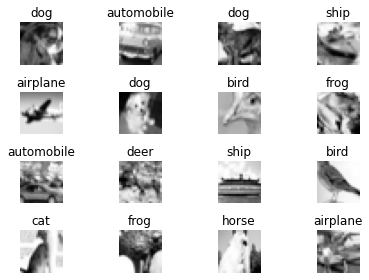

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
random.seed(1)

names, data, labels = read_data('./cifar-10-batches-py')

def show_some_examples(names, data, labels):
    plt.figure()
    rows, cols = 4, 4
    random_idxs = random.sample(range(len(data)), rows * cols)
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        j = random_idxs[i]
        plt.title(names[labels[j]])
        img = np.reshape(data[j, :], (24, 24))
        plt.imshow(img, cmap='Greys_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('cifar_examples.png')

show_some_examples(names, data, labels)

看看中间过程

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

names, data, labels = read_data('./cifar-10-batches-py')


def show_conv_results(data, filename=None):
    plt.figure()
    rows, cols = 4, 8
    for i in range(np.shape(data)[3]):
        img = data[0, :, :, i]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    if filename:
        plt.savefig(filename)
    else:
        plt.show()


def show_weights(W, filename=None):
    plt.figure()
    rows, cols = 4, 8
    for i in range(np.shape(W)[3]):
        img = W[:, :, 0, i]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

Instructions for updating:
non-resource variables are not supported in the long term
names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 3072) (50000,)


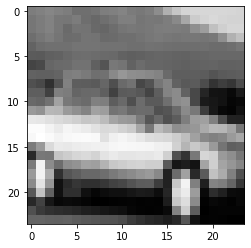

In [9]:
raw_data = data[4, :]
raw_img = np.reshape(raw_data, (24, 24))
plt.figure()
plt.imshow(raw_img, cmap='Greys_r')
plt.show()

In [10]:
x = tf.reshape(raw_data, shape=[-1, 24, 24, 1])
W = tf.Variable(tf.random_normal([5, 5, 1, 32]))
b = tf.Variable(tf.random_normal([32]))

conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
conv_with_b = tf.nn.bias_add(conv, b)
conv_out = tf.nn.relu(conv_with_b)

k = 2
maxpool = tf.nn.max_pool(conv_out, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

weights:


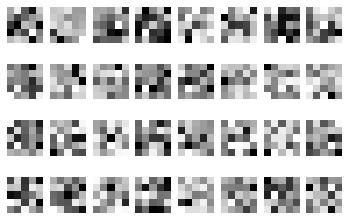

convolution results:
(1, 24, 24, 32)


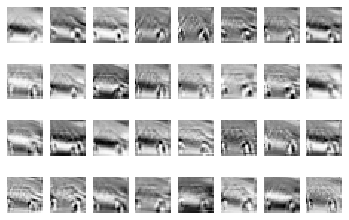

convolution with bias and relu:
(1, 24, 24, 32)


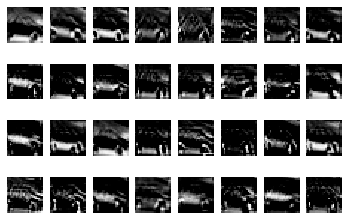

maxpool after all the convolutions:
(1, 12, 12, 32)


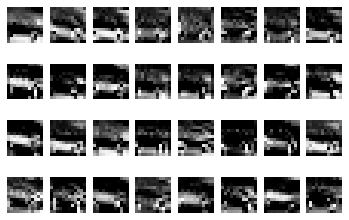

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    W_val = sess.run(W)
    print('weights:')
    show_weights(W_val)

    conv_val = sess.run(conv)
    print('convolution results:')
    print(np.shape(conv_val))
    show_conv_results(conv_val)
    

    conv_out_val = sess.run(conv_out)
    print('convolution with bias and relu:')
    print(np.shape(conv_out_val))
    show_conv_results(conv_out_val)


    maxpool_val = sess.run(maxpool)
    print('maxpool after all the convolutions:')
    print(np.shape(maxpool_val))
    show_conv_results(maxpool_val)

构建完整网络模型

In [12]:
x = tf.placeholder(tf.float32, [None, 24 * 24])
y = tf.placeholder(tf.float32, [None, len(names)])
W1 = tf.Variable(tf.random_normal([5, 5, 1, 64]))
b1 = tf.Variable(tf.random_normal([64]))
W2 = tf.Variable(tf.random_normal([5, 5, 64, 64]))
b2 = tf.Variable(tf.random_normal([64]))
W3 = tf.Variable(tf.random_normal([6*6*64, 1024]))
b3 = tf.Variable(tf.random_normal([1024]))
W_out = tf.Variable(tf.random_normal([1024, len(names)]))
b_out = tf.Variable(tf.random_normal([len(names)]))

In [13]:
def conv_layer(x, W, b):
    conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_with_b = tf.nn.bias_add(conv, b)
    conv_out = tf.nn.relu(conv_with_b)
    return conv_out


def maxpool_layer(conv, k=2):
    return tf.nn.max_pool(conv, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [14]:
def model():
    x_reshaped = tf.reshape(x, shape=[-1, 24, 24, 1])

    conv_out1 = conv_layer(x_reshaped, W1, b1)
    maxpool_out1 = maxpool_layer(conv_out1)
    #提出了LRN层，对局部神经元的活动创建竞争机制，使得其中响应比较大的值变得相对更大，并抑制其他反馈较小的神经元，增强了模型的泛化能力。
    #推荐阅读http://blog.csdn.net/banana1006034246/article/details/75204013
    norm1 = tf.nn.lrn(maxpool_out1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    conv_out2 = conv_layer(norm1, W2, b2)
    norm2 = tf.nn.lrn(conv_out2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    maxpool_out2 = maxpool_layer(norm2)

    maxpool_reshaped = tf.reshape(maxpool_out2, [-1, W3.get_shape().as_list()[0]])
    local = tf.add(tf.matmul(maxpool_reshaped, W3), b3)
    local_out = tf.nn.relu(local)

    out = tf.add(tf.matmul(local_out, W_out), b_out)
    return out

In [15]:
learning_rate = 0.001
model_op = model()

cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=model_op, labels=y)
)
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(model_op, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    onehot_labels = tf.one_hot(labels, len(names), axis=-1)
    onehot_vals = sess.run(onehot_labels)
    batch_size = 64
    print('batch size', batch_size)
    for j in range(0, 1000):
        avg_accuracy_val = 0.
        batch_count = 0.
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i+batch_size, :]
            batch_onehot_vals = onehot_vals[i:i+batch_size, :]
            _, accuracy_val = sess.run([train_op, accuracy], feed_dict={x: batch_data, y: batch_onehot_vals})
            avg_accuracy_val += accuracy_val
            batch_count += 1.
        avg_accuracy_val /= batch_count
        print('Epoch {}. Avg accuracy {}'.format(j, avg_accuracy_val))

batch size 64
Epoch 0. Avg accuracy 0.23163762787723785
Epoch 1. Avg accuracy 0.2853061061381074
Epoch 2. Avg accuracy 0.3078644501278772
Epoch 3. Avg accuracy 0.32374920076726343
Epoch 4. Avg accuracy 0.3361173273657289
Epoch 5. Avg accuracy 0.345548273657289
Epoch 6. Avg accuracy 0.35427989130434784
Epoch 7. Avg accuracy 0.3592950767263427
Epoch 8. Avg accuracy 0.3723825127877238
Epoch 9. Avg accuracy 0.3772178708439898
Epoch 10. Avg accuracy 0.3796755115089514
Epoch 11. Avg accuracy 0.3859694693094629
Epoch 12. Avg accuracy 0.38976582480818417
Epoch 13. Avg accuracy 0.3953804347826087
Epoch 14. Avg accuracy 0.4065297314578005
Epoch 15. Avg accuracy 0.406190057544757
Epoch 16. Avg accuracy 0.41679987212276215
Epoch 17. Avg accuracy 0.4189178388746803
Epoch 18. Avg accuracy 0.42135549872122763
Epoch 19. Avg accuracy 0.42363331202046034
Epoch 20. Avg accuracy 0.43404331841432225
Epoch 21. Avg accuracy 0.42820891943734013
Epoch 22. Avg accuracy 0.4390784846547315
Epoch 23. Avg accuracy 

Epoch 193. Avg accuracy 0.6351502557544757
Epoch 194. Avg accuracy 0.6351502557544757
Epoch 195. Avg accuracy 0.618366368286445
Epoch 196. Avg accuracy 0.6219229539641944
Epoch 197. Avg accuracy 0.6348705242966752
Epoch 198. Avg accuracy 0.6485174232736572
Epoch 199. Avg accuracy 0.661085358056266
Epoch 200. Avg accuracy 0.6682584718670077
Epoch 201. Avg accuracy 0.6702765345268542
Epoch 202. Avg accuracy 0.6785286125319693
Epoch 203. Avg accuracy 0.6776094948849105
Epoch 204. Avg accuracy 0.68440297314578
Epoch 205. Avg accuracy 0.6822250639386189
Epoch 206. Avg accuracy 0.6801070971867008
Epoch 207. Avg accuracy 0.6754315856777494
Epoch 208. Avg accuracy 0.6704963235294118
Epoch 209. Avg accuracy 0.6554307864450127
Epoch 210. Avg accuracy 0.6492367327365729
Epoch 211. Avg accuracy 0.6323329603580563
Epoch 212. Avg accuracy 0.6323329603580563
Epoch 213. Avg accuracy 0.6288962595907929
Epoch 214. Avg accuracy 0.6284367007672634
Epoch 215. Avg accuracy 0.6345108695652174


KeyboardInterrupt: 